Range of colors in the lesion:
Minimum RGB values: [185 137 116 255]
Maximum RGB values: [219 167 149 255]


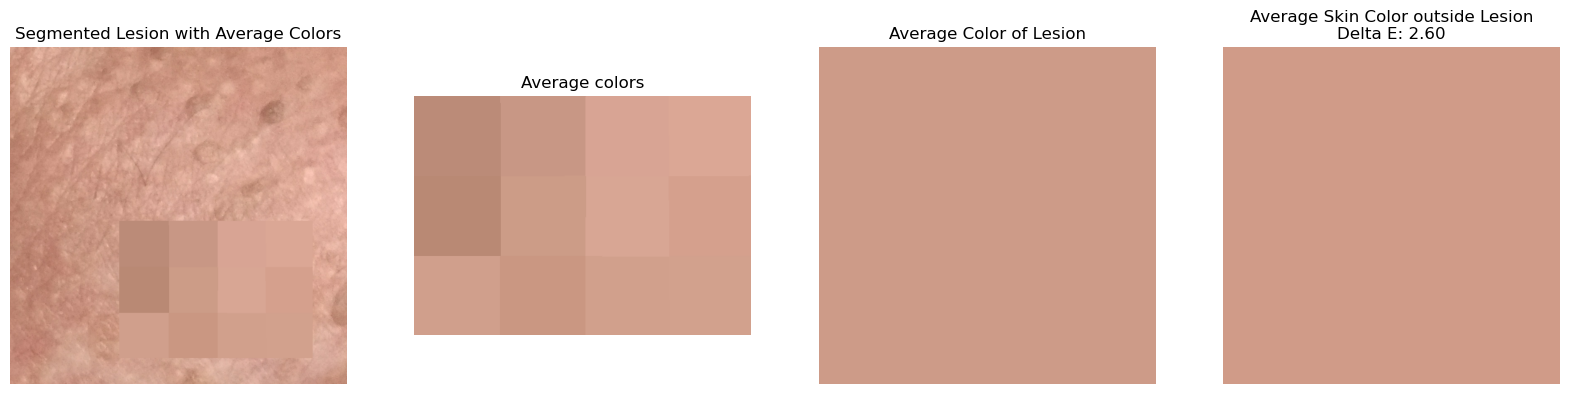

In [30]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from skimage import segmentation, color
from sklearn.metrics import euclidean_distances

# Load the image and its corresponding mask
image_path = 'PAT_1709_3159_144.png'
mask_path = 'PAT_1709_3159_144_mask.png'

image = Image.open(image_path)
mask = Image.open(mask_path).convert('L')

# Convert PIL image to numpy array
rgb_img = np.array(image)
mask = np.array(mask)

# Find coordinates of the lesion in the mask
lesion_coords = np.where(mask != 0)
min_x = min(lesion_coords[0])
max_x = max(lesion_coords[0])
min_y = min(lesion_coords[1])
max_y = max(lesion_coords[1])
cropped_lesion = rgb_img[min_x:max_x, min_y:max_y]

# Perform SLIC superpixel segmentation
labels1 = segmentation.slic(cropped_lesion, compactness=10, n_segments=10, sigma=3,
                            start_label=1)

# Calculate average color for each segment
segment_colors = []
for label in np.unique(labels1):
    if label == 0:
        continue
    mask_label = labels1 == label
    avg_color = np.mean(cropped_lesion[mask_label], axis=0)
    segment_colors.append(avg_color)

# Assign average colors back to the lesion area in the original image
for label, color in zip(np.unique(labels1), segment_colors):
    if label == 0:
        continue
    mask_label = labels1 == label
    rgb_img[min_x:max_x, min_y:max_y][mask_label] = color

# Calculate average color for the areas outside the lesion
skin_color = np.mean(rgb_img[mask == 0], axis=0)

# Calculate Delta E between average skin color and average lesion color
delta_e = np.linalg.norm(skin_color - np.mean(cropped_lesion, axis=(0, 1)))

# Calculate average color of all colors in the lesion
avg_lesion_color = np.mean(cropped_lesion, axis=(0, 1))

# Calculate the range of colors in the lesion
min_color = np.min(cropped_lesion, axis=(0, 1))
max_color = np.max(cropped_lesion, axis=(0, 1))

# Display the range of colors in the lesion
print("Range of colors in the lesion:")
print("Minimum RGB values:", min_color)
print("Maximum RGB values:", max_color)

# Display the results
plt.figure(figsize=(20, 10))

# Plot the segmented lesion with average colors
plt.subplot(1, 4, 1)
plt.imshow(rgb_img)
plt.title('Segmented Lesion with Average Colors')
plt.axis('off')

# Plot the Average colors
plt.subplot(1, 4, 2)
plt.imshow(cropped_lesion)
plt.title('Average colors')
plt.axis('off')

# Plot the average color of all colors in the lesion
plt.subplot(1, 4, 3)
plt.imshow([[[int(channel) for channel in avg_lesion_color]]])  # Create a single-pixel image with the average lesion color
plt.title('Average Color of Lesion')
plt.axis('off')

# Plot the average skin color outside the lesion
plt.subplot(1, 4, 4)
plt.imshow([[[int(channel) for channel in skin_color]]])  # Create a single-pixel image with the average skin color
plt.title(f'Average Skin Color outside Lesion\nDelta E: {delta_e:.2f}')
plt.axis('off')

plt.show()


In [31]:
# Calculate the variance of colors within the lesion
color_variance = np.var(cropped_lesion, axis=(0, 1))

# Compute the colorfulness score as the sum of variances across all channels
colorfulness_score = np.sum(color_variance)

# Display the colorfulness score
print("Colorfulness Score:", colorfulness_score)


Colorfulness Score: 304.41519461047216


In [32]:
##    Low Colorfulness (0 - 1000): The image or region contains minimal color variation and appears relatively dull 
##   or monochromatic.

##   Moderate Colorfulness (1000 - 5000): The image or region exhibits some color variation, but it may lack intensity 
## or diversity. Colors are noticeable but not particularly vibrant.

##   High Colorfulness (5000 - 10000): The image or region displays significant color variation with vibrant and diverse hues.
## Colors are vivid and eye-catching, contributing to a lively and dynamic appearance.

##  Very High Colorfulness (above 10000): The image or region features an abundance of intense and varied colors,
##  resembling a rainbow or a highly saturated scene. Colors are exceptionally vibrant and striking